In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 100000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

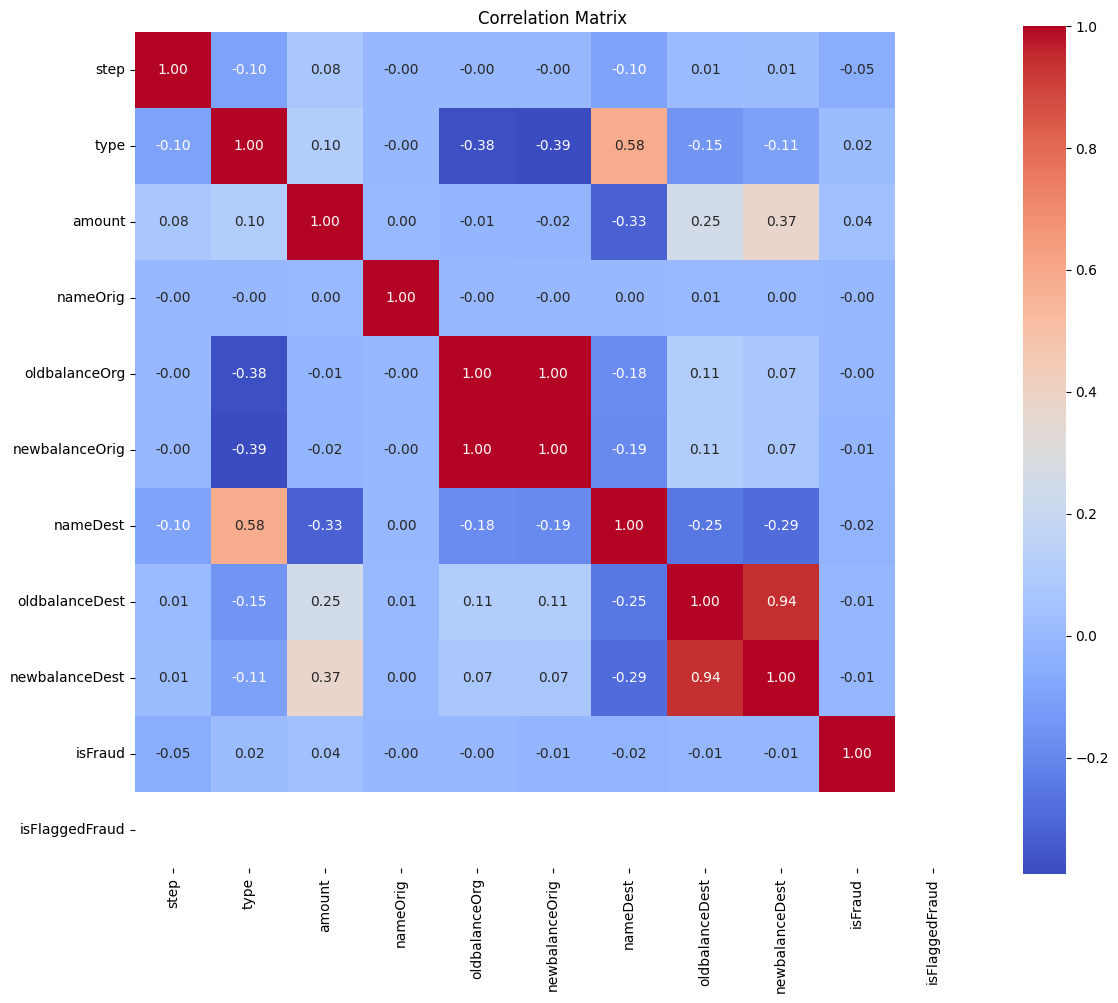

isFraud           1.000000
amount            0.036422
type              0.015555
nameOrig         -0.003244
oldbalanceOrg    -0.004144
newbalanceDest   -0.006394
oldbalanceDest   -0.009266
newbalanceOrig   -0.010872
nameDest         -0.022002
step             -0.051329
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


In [4]:
# Assuming 'df' is your full dataframe
plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

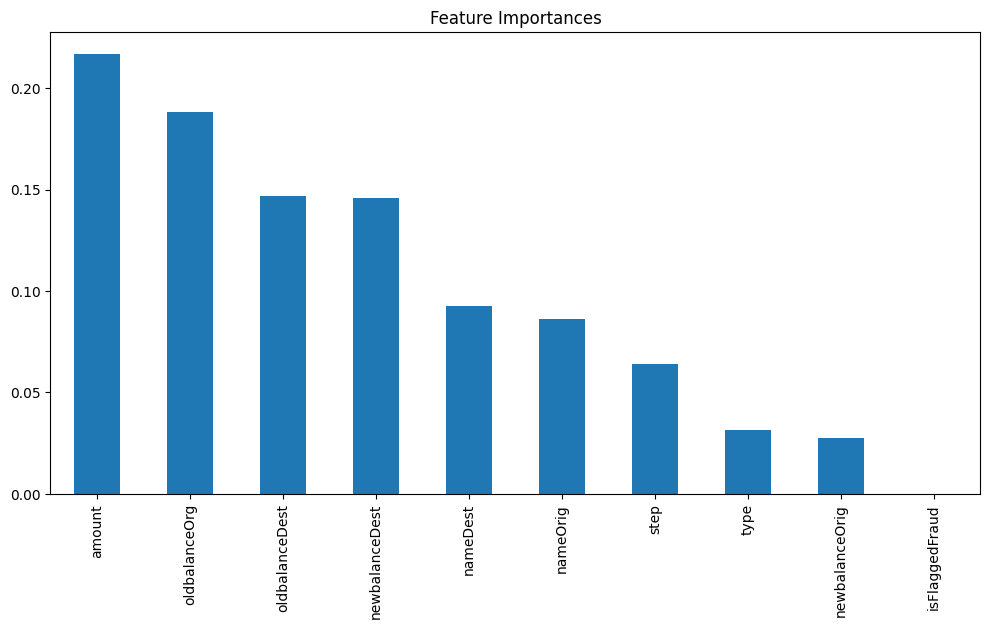

In [5]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

#determine the importance of each feature
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importances')
plt.show()

In [6]:
#dropping the least important features and feature engineering (maybe Ill remove the type and newbalance columns later)

df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)


In [7]:
'''
def Standard_Scaler(train_df, test_df, col_names):
    scaler = StandardScaler()
    
    # Fit on training data and transform both sets
    train_df[col_names] = scaler.fit_transform(train_df[col_names])
    test_df[col_names] = scaler.transform(test_df[col_names])
    
    return train_df, test_df

col_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X_train, X_test = Standard_Scaler(X_train, X_test, col_names)

X_train.head(5)
'''

"\ndef Standard_Scaler(train_df, test_df, col_names):\n    scaler = StandardScaler()\n    \n    # Fit on training data and transform both sets\n    train_df[col_names] = scaler.fit_transform(train_df[col_names])\n    test_df[col_names] = scaler.transform(test_df[col_names])\n    \n    return train_df, test_df\n\ncol_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']\nX_train, X_test = Standard_Scaler(X_train, X_test, col_names)\n\nX_train.head(5)\n"

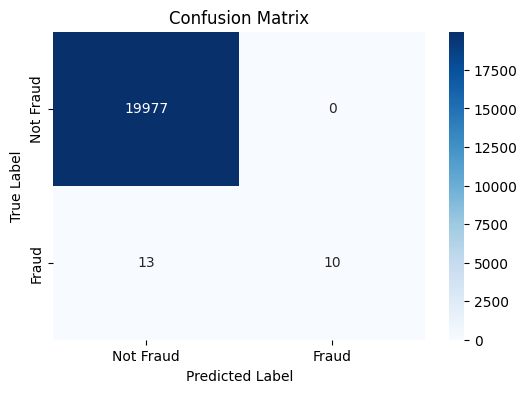

Random Forest Classifier Accuracy: [0.9993125 0.9993125 0.99925   0.999125  0.999125 ]
Cross Validation Recall scores are: [0.38888889 0.38888889 0.36842105 0.31578947 0.36842105]
Average Cross Validation Recall score: 0.36608187134502923
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19977
       Fraud       1.00      0.43      0.61        23

    accuracy                           1.00     20000
   macro avg       1.00      0.72      0.80     20000
weighted avg       1.00      1.00      1.00     20000



In [8]:
#training without sampling

kf = StratifiedKFold(n_splits=5, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, random_state=13)

rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

#sampling wtith SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_resampled.value_counts())


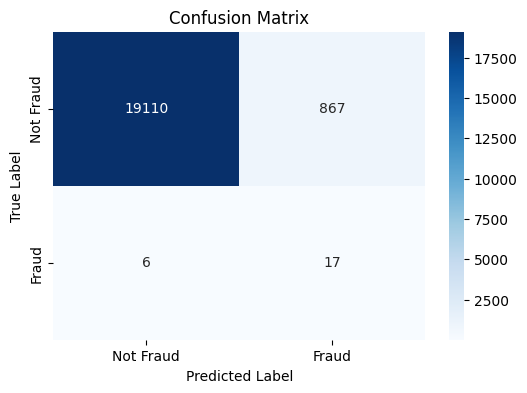

Random Forest Classifier Accuracy: [0.9589375 0.9558125 0.9606875 0.9661875 0.9611875]
Cross Validation Recall scores are: [0.77777778 0.61111111 0.73684211 0.68421053 0.89473684]
Average Cross Validation Recall score: 0.7409356725146199
              precision    recall  f1-score   support

   Not Fraud       1.00      0.96      0.98     19977
       Fraud       0.02      0.74      0.04        23

    accuracy                           0.96     20000
   macro avg       0.51      0.85      0.51     20000
weighted avg       1.00      0.96      0.98     20000



In [11]:
#training with SMOTE (with optimal parameters)

from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=False)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        random_state=13,
        max_depth=10,
        class_weight={0: 1, 1: 6}
    ))
])
#the weights should be around 1:6-1:7
#rf = RandomForestClassifier(n_estimators=1000, random_state=13, max_depth=10, class_weight={0: 1, 1: 6})
#rf.fit(X_train_resampled, y_train_resampled)

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

In [ ]:
# Hyperparameter grid to optimize recall
'''
rf = RandomForestClassifier(random_state=13)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters found:", grid_search.best_params_)
# Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'n_estimators': 500} n can be more
# Dont use this for now, it takes too long to run, so only run as one cell


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))
'''

NameError: name 'rf' is not defined